<h1 style="color:blue; background:lightblue; line-height:1.5; text-align:center">* Quora Question Pair Similarity using BERT and ML Models like XGBoost and Random Forest Classifier*</h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2 style="color:blue; background:pink; line-height:1.5">Import required libraries</h2>

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

<h2 style="color:blue; background:pink; line-height:1.5">Loading Dataset which has extracted features and Preprocessed</h2>

**Dataset link:** https://drive.google.com/file/d/1rxPJHAvSXzOPEpIqmaAsXvhJK8p4K4JN/view?usp=sharing


In [ ]:
df=pd.read_csv('data/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


<h2 style="color:blue; background:pink; line-height:1.5">Dataset information</h2>

In [ ]:
df.shape

(404290, 6)

In [ ]:
df.size

2425740

In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

<h2 style="color:blue; background:pink; line-height:1.5">Missing values</h2>

In [ ]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
df.dropna(inplace=True)
df.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

<h2 style="color:blue; background:pink; line-height:1.5">Duplicate Rows</h2>

In [ ]:
df.duplicated().sum()

0

<h2 style="color:blue; background:pink; line-height:1.5">Data Balance check</h2>

In [ ]:
class_balance=pd.DataFrame(df['is_duplicate'].value_counts()).reset_index()
class_balance.columns=["Class", "Count"]
class_balance['Percentage']=(class_balance['Count']/df.shape[0])*100
class_balance

,Class,Count,Percentage
0,0,255024,63.079941
1,1,149263,36.920059


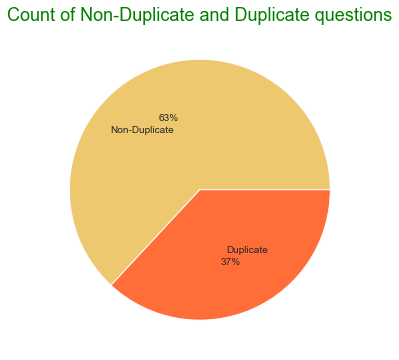

In [ ]:
label=['Non-Duplicate', 'Duplicate'] 
color=sns.color_palette('rainbow')[4:6]
plt.figure(figsize=(6,6))
plt.pie(x=class_balance['Count'], labels=label, colors=color, autopct='%.0f%%' , labeldistance=0.5)
plt.title("Count of Non-Duplicate and Duplicate questions", fontsize=18, color='green');

<h2 style="color:blue; background:pink; line-height:1.5">Data Balance using Simple Undersampling higher class</h2>

In [ ]:
class_1_df=df[df['is_duplicate']==1]
class_0_df=df[df['is_duplicate']==0]
print(class_1_df.shape)
print(class_0_df.shape)

(149263, 6)
(255024, 6)


In [ ]:
sample_class_1=class_1_df.sample(149263, random_state=0, ignore_index=True)
sample_class_0=class_0_df.sample(149263, random_state=0, ignore_index=True)
balanced=pd.concat([sample_class_1, sample_class_0], ignore_index=True)
balanced.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,35115,64212,64213,What minor would complement a Computer Science...,What is a good minor that will compliment a Co...,1
1,327832,454305,454306,How can I materialize an idea?,What is the best way to materialize on an idea?,1
2,239154,36437,107375,What was the happiest day of your life? And wh...,What (was/is/will be) the happiest day of your...,1
3,294056,415881,415882,What role Project manager has in Agile projects?,What is the role of project management in agil...,1
4,110452,76936,70278,Who will win in America presidential elections...,Between Trump and Clinton who will win US pres...,1


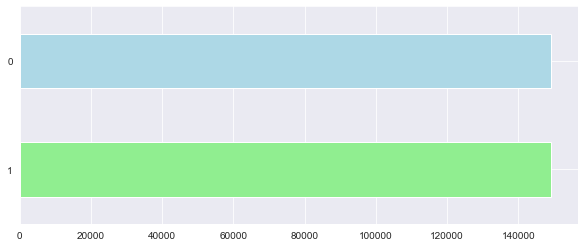

In [ ]:
balanced['is_duplicate'].value_counts().plot(kind='barh', figsize=(10,4), color=['lightgreen','lightblue']);

<h2 style="color:blue; background:pink; line-height:1.5">Text Preprocessing</h2>

In [ ]:
import contractions
import re

In [ ]:
balanced=balanced[['question1','question2','is_duplicate']]

In [ ]:
def clean_test_for_sample_data(text):
    text=str(text).lower()
    text=text.replace('%', ' percent')
    text=text.replace('$', ' dollar ')
    text=text.replace('₹', ' rupee ')
    text=text.replace('€', ' euro ')
    text=text.replace('@', ' at ')
        
    text=text.replace(',000,000,000 ', 'b ')
    text=text.replace(',000,000 ', 'm ')
    text=text.replace(',000 ', 'k ')
    text=re.sub(r'([0-9]+)000000000', r'\1b', text)
    text=re.sub(r'([0-9]+)000000', r'\1m', text)
    text=re.sub(r'([0-9]+)000', r'\1k', text)
    pattern=re.compile('\W')
    text=re.sub(pattern, ' ', text).strip()
    #text=" ".join(text)
    text=re.sub("<.*?>", "", text)
    text=contractions.fix(text)
    text=re.sub(" +", " ", text)
    #text=text.strip()
    return text

balanced['question1']=balanced['question1'].apply(clean_test_for_sample_data)
balanced['question2']=balanced['question2'].apply(clean_test_for_sample_data)
pd.options.display.max_colwidth=10000000000000
balanced.head()

,question1,question2,is_duplicate
0,what minor would complement a computer science major,what is a good minor that will compliment a computer science major,1
1,how can i materialize an idea,what is the best way to materialize on an idea,1
2,what was the happiest day of your life and why was it,what was is will be the happiest day of your life,1
3,what role project manager has in agile projects,what is the role of project management in agile software development,1
4,who will win in america presidential elections in 2016,between trump and clinton who will win us presidential election,1


<h2 style="color:blue; background:pink; line-height:1.5">Feature Extraction</h2>

<h2 style="color:blue; background:pink; line-height:1.5">1. Basic Features</h2>

In [ ]:
# 1. Question length
balanced['que1_len']=balanced['question1'].str.len()
balanced['que2_len']=balanced['question2'].str.len()

# 2. Number of words
balanced['que1_num_words'] =balanced['question1'].apply(lambda sent: len(sent.split()))
balanced['que2_num_words'] =balanced['question2'].apply(lambda sent: len(sent.split()))

# 3. Total words in both question
def total_words(row):
    q1_w=set(map(lambda x: x.lower().strip(), row['question1'].split()))
    q2_w=set(map(lambda x: x.lower().strip(), row['question2'].split()))
    return len(q1_w) + len(q2_w)

balanced['total_words']=balanced.apply(total_words, axis=1)

# 4. Common words in both questions
def common_words(row):
    q1_w=set(map(lambda x: x.lower().strip(), row['question1'].split()))
    q2_w=set(map(lambda x: x.lower().strip(), row['question2'].split()))
    return len(q1_w)&len(q2_w)

balanced['common_words']=balanced.apply(common_words, axis=1)

# 5. Word sharing
balanced['shared_words'] = round(balanced['common_words']/balanced['total_words'], 2)

balanced.head(2)

,question1,question2,is_duplicate,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words
0,what minor would complement a computer science major,what is a good minor that will compliment a computer science major,1,52,66,8,12,19,8,0.42
1,how can i materialize an idea,what is the best way to materialize on an idea,1,29,46,6,10,16,2,0.12


<h2 style="color:blue; background:lightgreen; line-height:1.5">Analyze Basic features</h2>

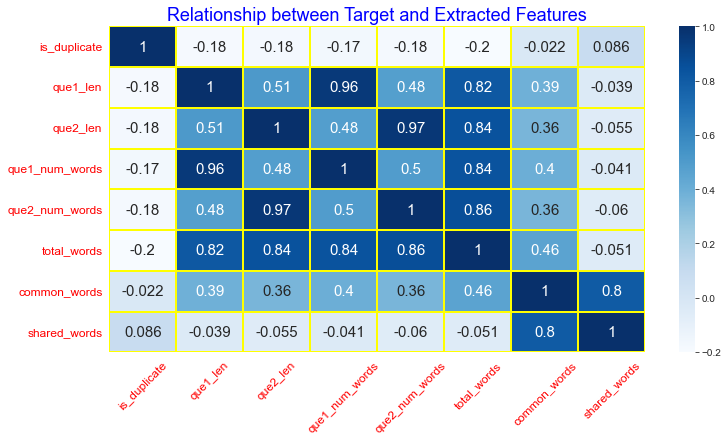

In [ ]:
corr=balanced.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap="Blues", linecolor='yellow', linewidths=2, annot_kws={"fontsize":15})
plt.xticks(fontsize=12, rotation=45, color='red')
plt.yticks(fontsize=12, color='red')
plt.title("Relationship between Target and Extracted Features", fontsize=18, color='blue');

<h2 style="color:blue; background:pink; line-height:1.5">2. Token Based Features</h2>

In [ ]:
from nltk.corpus import stopwords

def extract_token_features(row):
    q1=row['question1']
    q2=row['question2']
    SAFE_DIV=0.0001
    STOP_WORDS=stopwords.words("english")   #Stopwords
    token_features=[0.0]*8
    
    q1_tokens=q1.split()    #tokens in question1
    q2_tokens=q2.split()    #tokens in question2
    if len(q1_tokens)==0 or len(q2_tokens)==0:
        return token_features

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])     #non-stopwords in question1
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])     #non-stopwords in question2
    
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])         #stopwords in question1
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])         #stopwords in question2
    
    common_word_count = len(q1_words.intersection(q2_words))                   #non-stopword count
    common_stop_count = len(q1_stops.intersection(q2_stops))                   #common stopword count
    common_token_count=len(set(q1_tokens).intersection(set(q2_tokens)))        #common token count
    
    token_features[0]=common_word_count/(min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1]=common_word_count/(max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2]=common_stop_count/(min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3]=common_stop_count/(max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4]=common_token_count/(min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5]=common_token_count/(max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6]=int(q1_tokens[-1]==q2_tokens[-1])   #last word same or not
    token_features[7]=int(q1_tokens[0]==q2_tokens[0])     #first word same or not
    
    return token_features

In [ ]:
token_features=balanced.apply(extract_token_features, axis=1)

balanced["cwc_min"]=list(map(lambda x: x[0], token_features))
balanced["cwc_max"]=list(map(lambda x: x[1], token_features))
balanced["csc_min"]=list(map(lambda x: x[2], token_features))
balanced["csc_max"]=list(map(lambda x: x[3], token_features))
balanced["ctc_min"]= list(map(lambda x: x[4], token_features))
balanced["ctc_max"]=list(map(lambda x: x[5], token_features))
balanced["last_word_eq"]=list(map(lambda x: x[6], token_features))
balanced["first_word_eq"]=list(map(lambda x: x[7], token_features))

balanced.head(2)

,question1,question2,is_duplicate,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,what minor would complement a computer science major,what is a good minor that will compliment a computer science major,1,52,66,8,12,19,8,0.42,0.666656,0.666656,0.999950,0.399992,0.749991,0.499996,1.0,1.0
1,how can i materialize an idea,what is the best way to materialize on an idea,1,29,46,6,10,16,2,0.12,0.999950,0.499988,0.249994,0.166664,0.499992,0.299997,1.0,0.0


<h2 style="color:blue; background:lightgreen; line-height:1.5"> Analyze Token Based Features</h2>

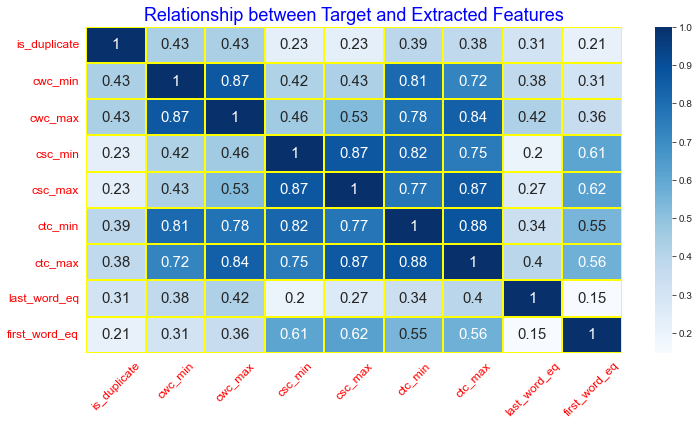

In [ ]:
token_features_df=balanced[['is_duplicate','cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq']]
corr=token_features_df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap="Blues", linecolor='yellow', linewidths=2, annot_kws={"fontsize":15})
plt.xticks(fontsize=12, rotation=45, color='red')
plt.yticks(fontsize=12, color='red')
plt.title("Relationship between Target and Extracted Features", fontsize=18, color='blue');

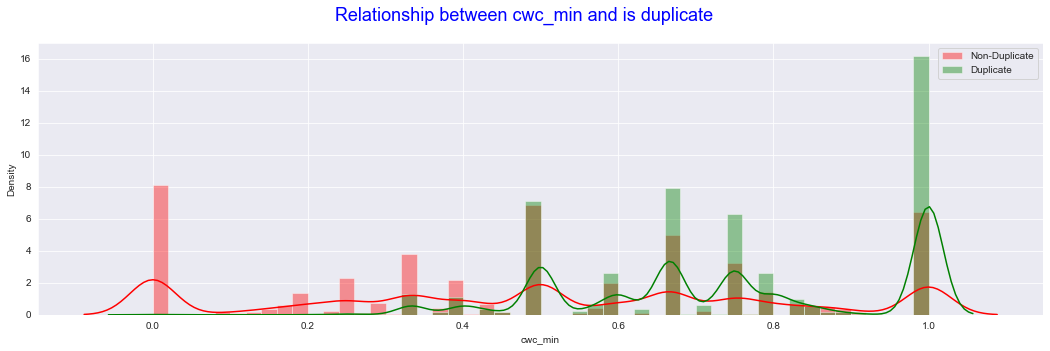

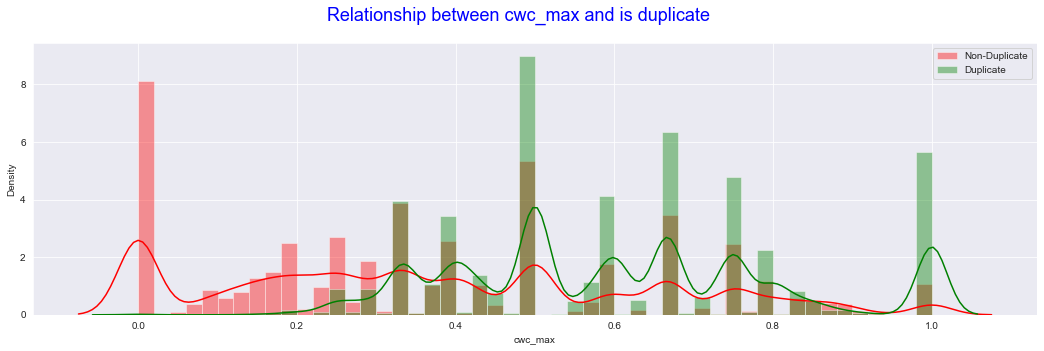

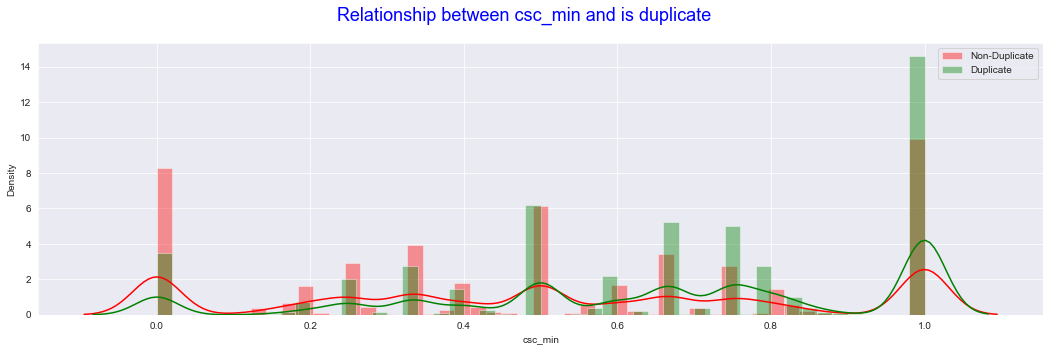

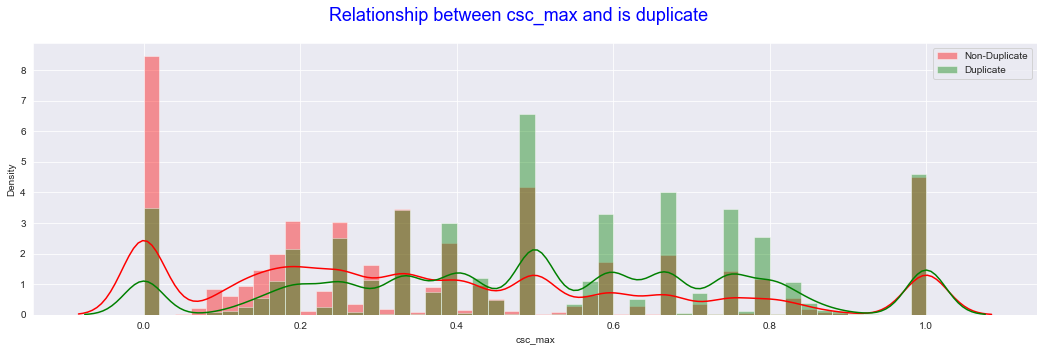

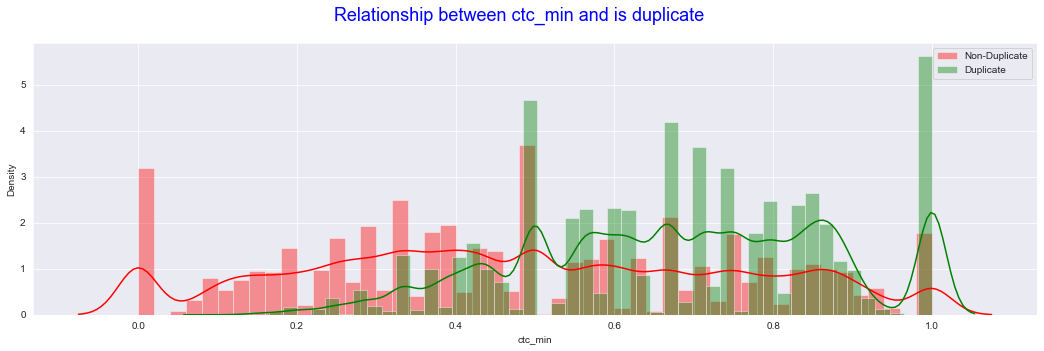

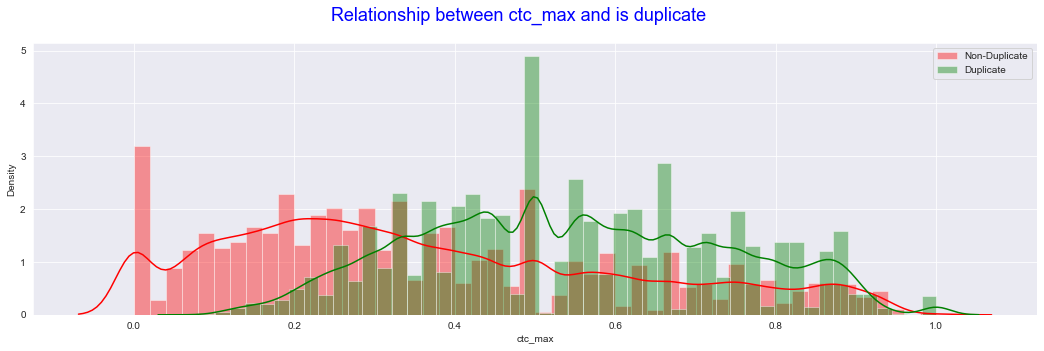

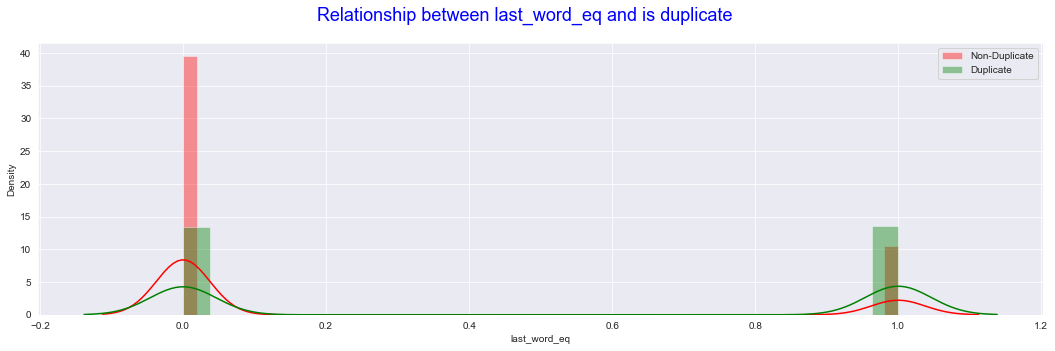

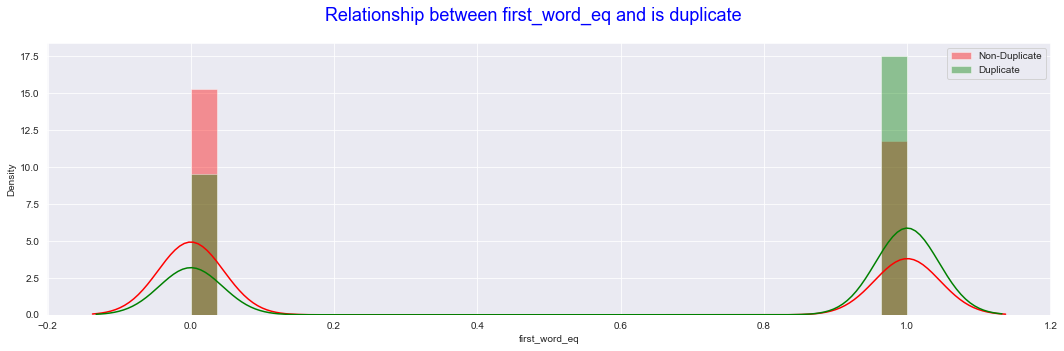

In [ ]:
token_features_df=token_features_df.drop('is_duplicate', axis=1)
for col in token_features_df.columns:
    plt.figure(figsize=(18,5))
    sns.distplot(balanced[balanced['is_duplicate'] == 0][col], label='Non-Duplicate', color='red')
    sns.distplot(balanced[balanced['is_duplicate'] == 1][col], label='Duplicate', color='green')
    plt.legend();
    plt.suptitle("Relationship between {} and is duplicate".format(col), color='blue', fontsize=18);

<h2 style="color:blue; background:pink; line-height:1.5">3. Length Based Features</h2>

In [ ]:
import distance
def extract_length_features(row):
    q1=row['question1']
    q2=row['question2']
    length_features=[0.0]*3
    
    q1_tokens=q1.split()   #question1 token
    q2_tokens=q2.split()   #question2 token
    if len(q1_tokens)==0 or len(q2_tokens)==0:
        return length_features
    
    length_features[0]=abs(len(q1_tokens) - len(q2_tokens))            #absolute length
    length_features[1]=(len(q1_tokens) + len(q2_tokens))/2             #average token length
    strs=list(distance.lcsubstrings(q1, q2))                           #longest substring
    length_features[2]=len(strs) / (min(len(q1), len(q2)) + 1)         #longest substring ratio
    
    return length_features

In [ ]:
length_features=balanced.apply(extract_length_features, axis=1)

balanced['abs_len_diff']=list(map(lambda x: x[0], length_features))
balanced['mean_len']=list(map(lambda x: x[1], length_features))
balanced['long_substr_ratio']=list(map(lambda x: x[2], length_features))

balanced.head(2)

,question1,question2,is_duplicate,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,long_substr_ratio
0,what minor would complement a computer science major,what is a good minor that will compliment a computer science major,1,52,66,8,12,19,8,0.42,...,0.666656,0.999950,0.399992,0.749991,0.499996,1.0,1.0,4.0,10.0,0.018868
1,how can i materialize an idea,what is the best way to materialize on an idea,1,29,46,6,10,16,2,0.12,...,0.499988,0.249994,0.166664,0.499992,0.299997,1.0,0.0,4.0,8.0,0.033333


<h2 style="color:blue; background:lightgreen; line-height:1.5">Analyze Length Based Features</h2>

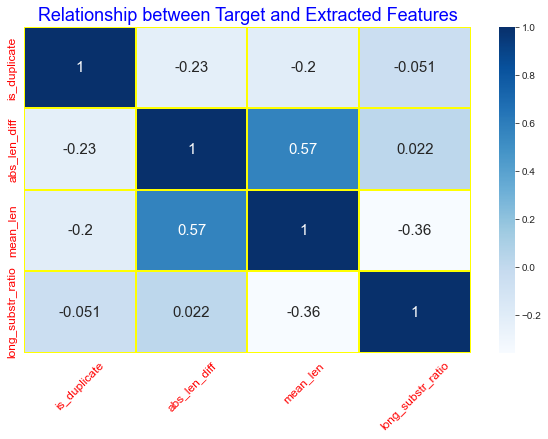

In [ ]:
length_features_df=balanced[['is_duplicate','abs_len_diff','mean_len','long_substr_ratio']]
corr=length_features_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="Blues", linecolor='yellow', linewidths=2, annot_kws={"fontsize":15})
plt.xticks(fontsize=12, rotation=45, color='red')
plt.yticks(fontsize=12, color='red')
plt.title("Relationship between Target and Extracted Features", fontsize=18, color='blue');

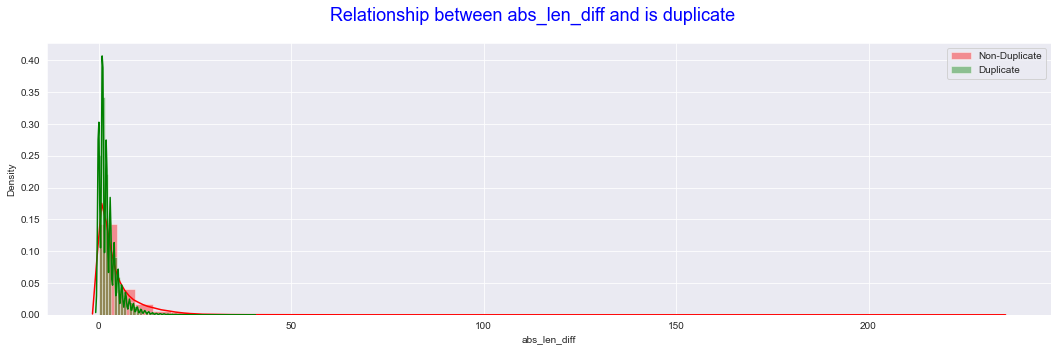

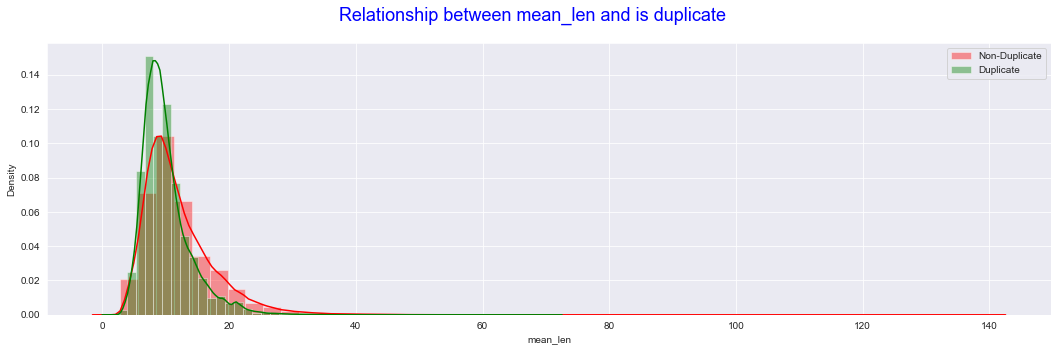

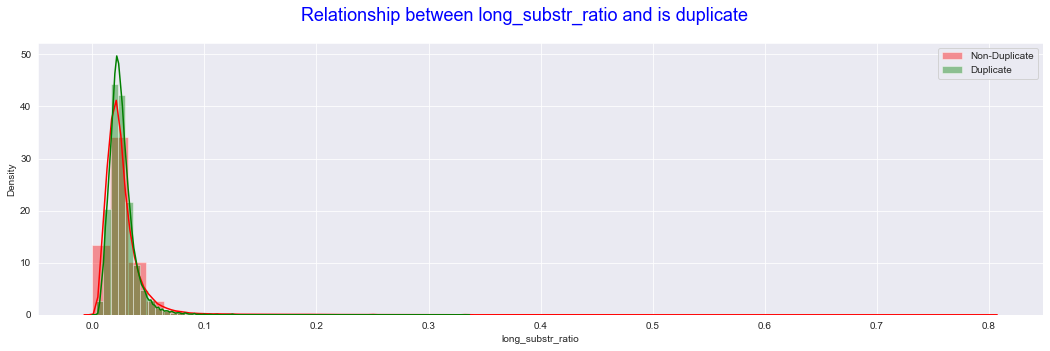

In [ ]:
length_features_df=length_features_df.drop('is_duplicate', axis=1)
for col in length_features_df.columns:
    plt.figure(figsize=(18,5))
    sns.distplot(balanced[balanced['is_duplicate'] == 0][col], label='Non-Duplicate', color='red')
    sns.distplot(balanced[balanced['is_duplicate'] == 1][col], label='Duplicate', color='green')
    plt.legend();
    plt.suptitle("Relationship between {} and is duplicate".format(col), color='blue', fontsize=18);

<h2 style="color:blue; background:pink; line-height:1.5">4. Fuzzy Features</h2>

In [ ]:
from fuzzywuzzy import fuzz
def extract_fuzzy_features(row):
    q1=row['question1']
    q2=row['question2']
    fuzzy_features=[0.0]*4
    
    fuzzy_features[0]=fuzz.QRatio(q1, q2)              #fuzzy ration
    fuzzy_features[1]=fuzz.partial_ratio(q1, q2)       #fuzzy partial_ratio
    fuzzy_features[2]=fuzz.token_sort_ratio(q1, q2)    #token sort ratio
    fuzzy_features[3]=fuzz.token_set_ratio(q1, q2)     #token set ratio

    return fuzzy_features

In [ ]:
fuzzy_features=balanced.apply(extract_fuzzy_features, axis=1)

balanced['fuzz_ratio']=list(map(lambda x: x[0], fuzzy_features))
balanced['fuzz_partial_ratio']=list(map(lambda x: x[1], fuzzy_features))
balanced['token_sort_ratio']=list(map(lambda x: x[2], fuzzy_features))
balanced['token_set_ratio']=list(map(lambda x: x[3], fuzzy_features))

balanced.head(2)

,question1,question2,is_duplicate,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,long_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,what minor would complement a computer science major,what is a good minor that will compliment a computer science major,1,52,66,8,12,19,8,0.42,...,0.499996,1.0,1.0,4.0,10.0,0.018868,81,85,81,83
1,how can i materialize an idea,what is the best way to materialize on an idea,1,29,46,6,10,16,2,0.12,...,0.299997,1.0,0.0,4.0,8.0,0.033333,64,72,53,79


<h2 style="color:blue; background:lightgreen; line-height:1.5">Analyze Fuzzy Features</h2>

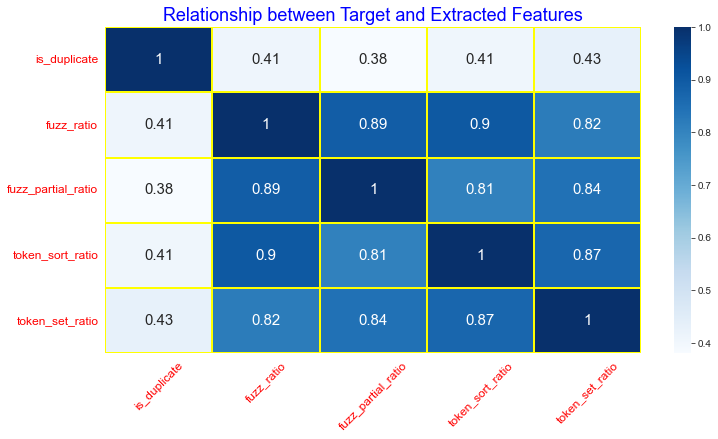

In [ ]:
fuzzy_features_df=balanced[['is_duplicate','fuzz_ratio','fuzz_partial_ratio','token_sort_ratio','token_set_ratio']]
corr=fuzzy_features_df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap="Blues", linecolor='yellow', linewidths=2, annot_kws={"fontsize":15})
plt.xticks(fontsize=12, rotation=45, color='red')
plt.yticks(fontsize=12, color='red')
plt.title("Relationship between Target and Extracted Features", fontsize=18, color='blue');

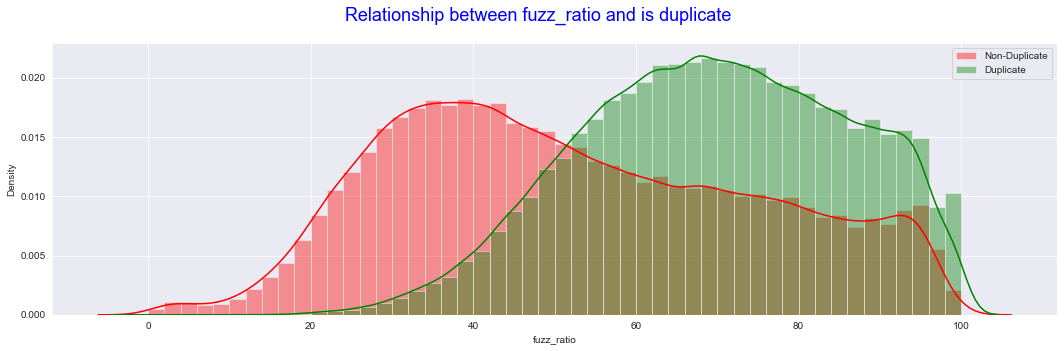

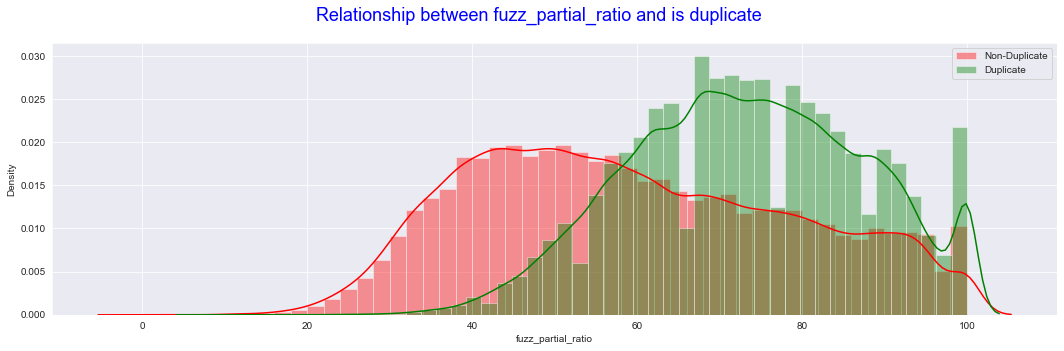

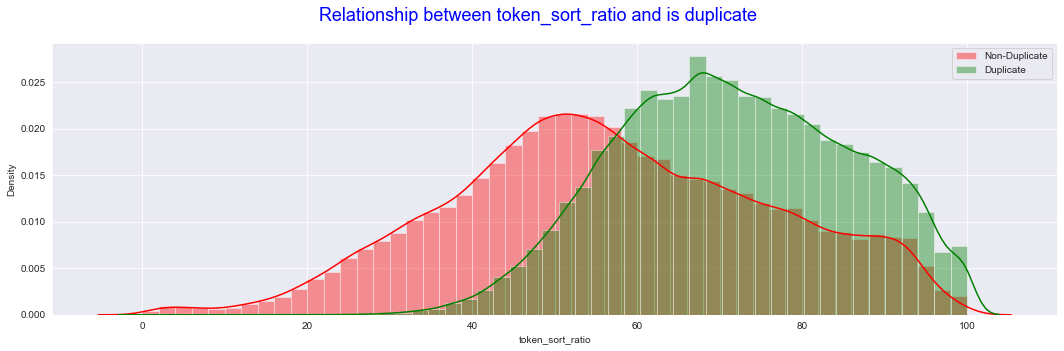

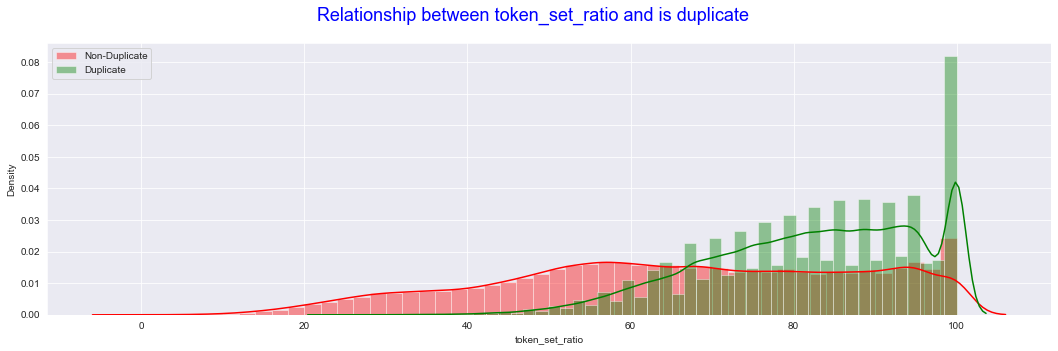

In [ ]:
fuzzy_features_df=fuzzy_features_df.drop('is_duplicate', axis=1)
for col in fuzzy_features_df.columns:
    plt.figure(figsize=(18,5))
    sns.distplot(balanced[balanced['is_duplicate'] == 0][col], label='Non-Duplicate', color='red')
    sns.distplot(balanced[balanced['is_duplicate'] == 1][col], label='Duplicate', color='green')
    plt.legend();
    plt.suptitle("Relationship between {} and is duplicate".format(col), color='blue', fontsize=18);

### Save this dataset with extreacted features

In [3]:
#balanced.to_csv("data/feat_extr_data_full.csv", index=False)
balanced=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Final_ Project_Quora_Question_Pair_Similarity/data/feat_extr_data_lakh.csv")
balanced.head(5)

,question1,question2,is_duplicate,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,long_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,what minor would complement a computer science...,what is a good minor that will compliment a co...,1,52,66,8,12,19,8,0.42,...,0.499996,1.0,1.0,4.0,10.0,0.018868,81,85,81,83
1,how can i materialize an idea,what is the best way to materialize on an idea,1,29,46,6,10,16,2,0.12,...,0.299997,1.0,0.0,4.0,8.0,0.033333,64,72,53,79
2,what was the happiest day of your life and why...,what was is will be the happiest day of your life,1,53,49,12,11,22,11,0.50,...,0.666661,0.0,1.0,1.0,11.5,0.020000,75,78,84,88
3,what role project manager has in agile projects,what is the role of project management in agil...,1,47,68,8,11,19,8,0.42,...,0.454541,0.0,1.0,3.0,9.5,0.020833,64,70,59,71
4,who will win in america presidential elections...,between trump and clinton who will win us pres...,1,54,63,9,10,18,8,0.44,...,0.399996,0.0,0.0,1.0,9.5,0.018182,60,77,65,68


In [4]:
balanced.shape

(298526, 25)

In [5]:
balanced.isna().sum()

question1             5
question2             2
is_duplicate          0
que1_len              0
que2_len              0
que1_num_words        0
que2_num_words        0
total_words           0
common_words          0
shared_words          0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
last_word_eq          0
first_word_eq         0
abs_len_diff          0
mean_len              0
long_substr_ratio     0
fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

In [6]:
balanced.dropna(inplace=True)
balanced.isna().sum()

question1             0
question2             0
is_duplicate          0
que1_len              0
que2_len              0
que1_num_words        0
que2_num_words        0
total_words           0
common_words          0
shared_words          0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
last_word_eq          0
first_word_eq         0
abs_len_diff          0
mean_len              0
long_substr_ratio     0
fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

In [7]:
balanced.duplicated().sum()

678

In [8]:
balanced.drop_duplicates(inplace=True)
balanced.duplicated().sum()

0

In [9]:
balanced.shape

(297841, 25)

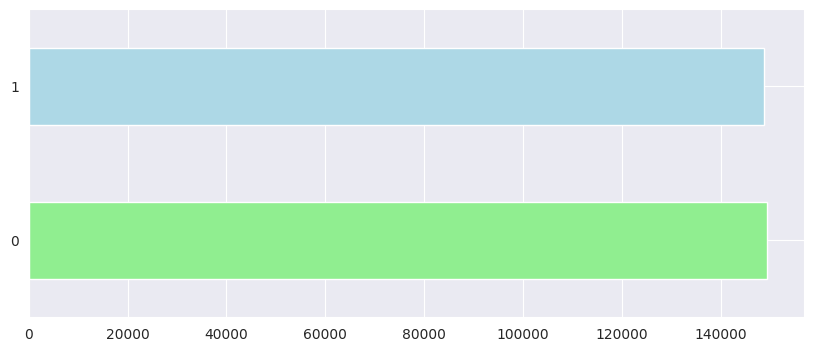

In [10]:
balanced['is_duplicate'].value_counts().plot(kind='barh', figsize=(10,4), color=['lightgreen','lightblue']);

<h2 style="color:blue; background:pink; line-height:1.5">Divide Data into Input and Output</h2>

In [11]:
X=balanced.drop('is_duplicate', axis=1)
y=balanced['is_duplicate']
print(X.shape, y.shape)

(297841, 24) (297841,)


<h2 style="color:blue; background:pink; line-height:1.5">Train Test Split</h2>

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape,x_test.shape,y_test.shape)

(238272, 24) (238272,) (59569, 24) (59569,)


<h2 style="color:blue; background:pink; line-height:1.5">Seperate Extracted features and BERT to Question1 and Question2 Seperately and concatenate extracted features to question1 and question2 vectors to create final train and test data.</h2>

In [13]:
x_train_questions1=list(x_train['question1'])
x_train_questions2=list(x_train['question2'])
x_test_questions1=list(x_test['question1'])
x_test_questions2=list(x_test['question2'])
print(x_train_questions1[1])
print(x_test_questions1[1])
print("--"*30)

how do i get rank in ca cpt
what high potential jobs are there other than computer science
------------------------------------------------------------


In [14]:
extracted_features=['que1_len', 'que2_len',
       'que1_num_words', 'que2_num_words', 'total_words', 'common_words',
       'shared_words', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'long_substr_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio']

x_train_extracted_features=x_train[extracted_features]
x_test_extracted_features=x_test[extracted_features]

x_train_extracted_features[:2]

,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,cwc_min,cwc_max,csc_min,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,long_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
173695,73,48,18,12,26,11,0.42,0.499992,0.428565,0.199996,...,0.222221,0.0,0.0,6.0,15.0,0.020408,36,51,45,48
68920,27,30,8,9,17,8,0.47,0.999975,0.999975,0.749981,...,0.777769,1.0,1.0,1.0,8.5,0.035714,88,81,84,94


<h2 style="color:blue; background:pink; line-height:1.5">Create Document vector for both question in train and test using pre-trained BERT</h2>

In [15]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 124.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 127.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=d0687c00ab22017b585d14327a5e38d2ae47c0603bd44610cf6c8602c9ed92b3
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [16]:
from sentence_transformers import SentenceTransformer, util
model=SentenceTransformer('all-MiniLM-L6-v2')

In [17]:
x_train_doc_vector1=list(x_train['question1'].apply(model.encode))
x_train_doc_vector2=list(x_train['question2'].apply(model.encode))

x_test_doc_vector1=list(x_test['question1'].apply(model.encode))
x_test_doc_vector2=list(x_test['question2'].apply(model.encode))

In [18]:
x_test_doc_vector2[1]

array([ 1.05806976e-03, -3.53207625e-02,  3.51864025e-02,  6.65499121e-02,
        6.12707958e-02, -3.01799849e-02, -2.55826768e-02,  5.27066514e-02,
       -4.20784168e-02,  1.09218052e-02, -8.57491568e-02, -1.64794251e-02,
        3.12465280e-02, -1.27335265e-03, -4.08720598e-02,  2.29676329e-02,
       -6.34287950e-03, -1.57045424e-01, -1.02301426e-02, -1.47460863e-01,
       -5.80395106e-03,  5.70384040e-02, -4.43123747e-03, -5.84523454e-02,
        4.22564410e-02,  4.48548719e-02, -4.46319468e-02, -6.00877032e-02,
       -4.89268079e-02, -1.64629743e-02, -1.15052797e-01,  1.04326032e-01,
        2.33975220e-02,  3.43010724e-02, -7.34224468e-02,  3.87859605e-02,
        1.18298810e-02, -5.86371683e-02,  2.68907323e-02, -4.49354313e-02,
       -1.57001370e-04,  7.71272276e-03,  3.02752294e-02, -1.31286876e-02,
       -2.11598277e-02,  1.10003874e-02,  1.03271902e-02, -1.53901860e-01,
        2.02162582e-02,  1.59394089e-03, -7.34559745e-02, -1.74928997e-02,
        4.99328040e-02, -

<h2 style="color:blue; background:pink; line-height:1.5">Finalize training and testing data</h2>

In [19]:
x_train_extracted_features_array=np.array(x_train_extracted_features)
x_test_extracted_features_array=np.array(x_test_extracted_features)

x_train_embedded_document_array=np.hstack((x_train_doc_vector1, x_train_doc_vector2))
x_test_embedded_document_array=np.hstack((x_test_doc_vector1, x_test_doc_vector2))

x_train=np.hstack((x_train_extracted_features_array, x_train_embedded_document_array))
x_test=np.hstack((x_test_extracted_features_array, x_test_embedded_document_array))

y_train=np.array(y_train)
y_test=np.array(y_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(238272, 790) (238272,) (59569, 790) (59569,)


<h2 style="color:blue; background:pink; line-height:1.5">Building Machine Learning Model</h2>

<h2 style="color:blue; background:pink;">Set Experiment<h2>

In [22]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143860 sha256=c28a640fc967cc45dadc468569a5d9ca98e330912fac510adfe33b62e5ae3a91
  Stored in directory: /root/.cache/pip/wheels

In [23]:
import mlflow
mlflow.set_experiment("Advance_approach_using_pre_trained_models")

2023/06/07 05:47:21 INFO mlflow.tracking.fluent: Experiment with name 'Advance_approach_using_pre_trained_models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/880652283275611363', creation_time=1686116841942, experiment_id='880652283275611363', last_update_time=1686116841942, lifecycle_stage='active', name='Advance_approach_using_pre_trained_models', tags={}>

<h2 style="color:blue; background:lightgreen; line-height:1.5">1. XG Boost<h2>

----------------------------------------------------------
Acuuracy=0.8527421981231849
Precission=0.8226244064870198
Recall=0.8983501683501683
F1 Score=0.8588212572826472
----------------------------------------------------------
Confusion Matrix=



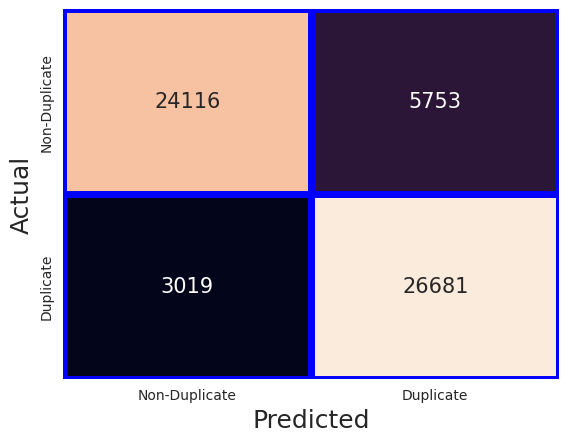

----------------------------------------------------------
Out of 59569 testing values 8772 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.89      0.81      0.85     29869
           1       0.82      0.90      0.86     29700

    accuracy                           0.85     59569
   macro avg       0.86      0.85      0.85     59569
weighted avg       0.86      0.85      0.85     59569

----------------------------------------------------------


In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "XG Boost bert extr")
    
    xgb_classifier=XGBClassifier()
    xgb_classifier.fit(x_train,y_train)
    pickle.dump(xgb_classifier, open("/content/resources_advance_approach_using_pre_trained_model/xgboost_bert_extr.pkl","wb"))
    
    y_pred=xgb_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("/content/resources_advance_approach_using_pre_trained_model/xgboost_bert_extr_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(xgb_classifier, artifact_path="models")
    mlflow.log_artifact("/content/resources_advance_approach_using_pre_trained_model/xgboost_bert_extr_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1.5">2. Random Forest Classifier<h2>

----------------------------------------------------------
Acuuracy=0.8232973526498683
Precission=0.780995369013424
Recall=0.8971717171717172
F1 Score=0.8350622081544392
----------------------------------------------------------
Confusion Matrix=



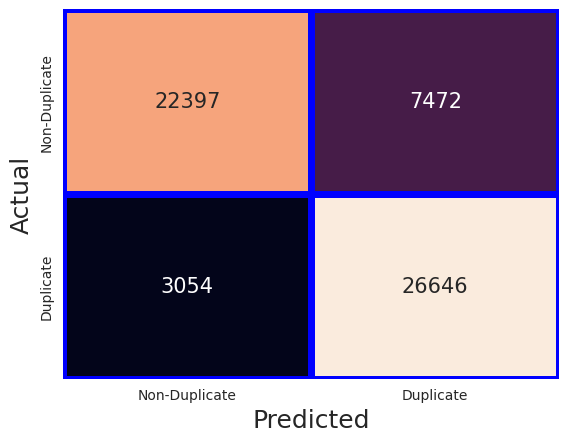

----------------------------------------------------------
Out of 59569 testing values 10526 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.88      0.75      0.81     29869
           1       0.78      0.90      0.84     29700

    accuracy                           0.82     59569
   macro avg       0.83      0.82      0.82     59569
weighted avg       0.83      0.82      0.82     59569

----------------------------------------------------------


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Random Forest bert extr")
    
    rf_classifier=RandomForestClassifier()
    rf_classifier.fit(x_train,y_train)
    pickle.dump(rf_classifier, open("/content/resources_advance_approach_using_pre_trained_model/random_forest_bert_extr.pkl","wb"))
    
    y_pred=rf_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("/content/resources_advance_approach_using_pre_trained_model/random_forest_bert_extr_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(rf_classifier, artifact_path="models")
    mlflow.log_artifact("/content/resources_advance_approach_using_pre_trained_model/random_forest_bert_extr_conf_matrix.png")

In [26]:
import shutil
shutil.make_archive('mlruns', 'zip', 'mlruns')

shutil.make_archive('resources_advance_approach_using_pre_trained_model', 'zip', 'resources_advance_approach_using_pre_trained_model')

'/content/resources_advance_approach_using_pre_trained_model.zip'